In [1]:
%run functions.ipynb

np.set_printoptions(precision=3)
np.random.seed(42)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
X_train, X_test, y_train, y_test = load_train_and_test_parts()
print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
print(
    "(1, 0) labels count in train test: {} {}".format(
        (np.count_nonzero(y_train == 1), np.count_nonzero(y_train == 0)),
        (np.count_nonzero(y_test == 1), np.count_nonzero(y_test == 0)),
    )
)

Train and test sizes: (726, 12179) (243, 12179)
(1, 0) labels count in train test: (289, 437) (104, 139)


In [3]:
n_iter = 1
cv = 4
n_jobs = 3
scoring = 'roc_auc'

## [fDNN](https://www.nature.com/articles/s41598-018-34833-6) model

In [4]:
clf_params = {'hidden_layer_sizes' : [[10,5] , [10, 10], [5,5]], 'alpha' : [0.01, 0.1, 1, 5, 10, 20]}
dim_params = {'n_components' : [100, 250, 500]}

In [5]:
red_rf = RepresentationTransformer(RandomForestClassifier(max_depth=5, min_samples_leaf=20))
clf = MLPClassifier(max_iter=1000)
models_rf = fit_dim_reduction_pipeline(red_rf, clf, dim_params, clf_params, X_train, y_train, n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring)

In [6]:
models_rf = clf_print_scores(models_rf, X_train, y_train, X_test, y_test)

Pipeline(memory=None,
     steps=[('dim', RepresentationTransformer(clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_spl...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])


,ROC AUC,Precision,Recall,F1
train,1.000,1.000,1.000,1.000
test,0.779,0.686,0.673,0.680


In [7]:
red_rlr = RepresentationTransformer(RandomLogisticsRegressions(penalty='l1', C=0.5, n_variables=500))
clf = MLPClassifier(max_iter=1000)
models_rlr = fit_dim_reduction_pipeline(red_rlr, clf, dim_params, clf_params, X_train, y_train, n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring)

In [8]:
models_rlr = clf_print_scores(models_rlr, X_train, y_train, X_test, y_test)

Pipeline(memory=None,
     steps=[('dim', RepresentationTransformer(clf=RandomLogisticsRegressions(C=0.5, n_estimators=100, n_variables=500,
              penalty='l1', solver='liblinear', tol=0.0001),
             n_components=100, probabilistic=True)), ('clf', MLPClassifier(activation='relu', alpha=1, batch_size='auto', bet...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))])


,ROC AUC,Precision,Recall,F1
train,0.982,0.941,0.934,0.938
test,0.806,0.692,0.712,0.701


In [ ]:
# extracting and plotting nnet coefficients
# coefs = flatten([coef.flatten().tolist() for coef in clf_nnet.coefs_])
# plt.hist(coefs, bins=bins)

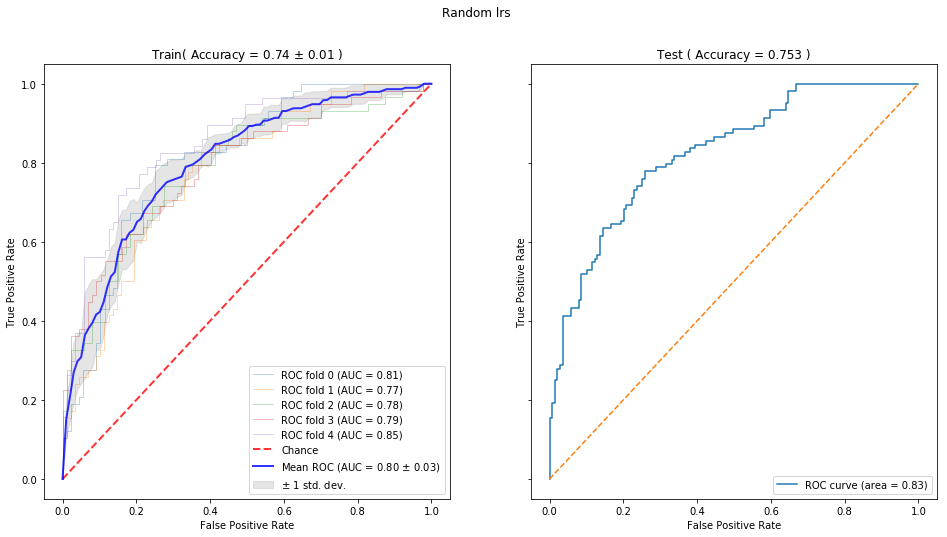

In [219]:
clf_random_lrs = fit_clf_with_cross_val(RandomLogisticsRegressions(n_estimators=21, penalty='l1', C=0.3, n_variables=2000), X_train, y_train, X_test, y_test, title='Random lrs')